In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.model.data import __version__

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from src.base import logger
from src.config import get_config
from src.model.data import make_dataset
from src.model.features import build_features
from src.model.preprocessing import PreProcessor

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

#from xgboost import XGBClassifier


pd.options.display.max_columns = None

%config IPCompleter.use_jedi=False

In [10]:
# Getting data information
data_config = get_config(filename="config/model.yaml")
features_config = get_config(filename="config/features.yaml")

# Construct the dataset
data  = make_dataset(data_config, download_bases=False)
X,y = build_features(data)

# Splitting in train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

# Train preprocessor
preprocessor = PreProcessor(features_config)
preprocessor.fit(X_train)

# Tranforming features
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

# Converting values

for col in X_train.columns:
    try:
        X_train[col] = X_train[col].astype(float)
    except:
        pass

    try:
        X_test[col] = X_test[col].astype(float)
    except:
        pass

In [11]:
data_train = X_train.assign(y=y_train)

data_train.corr()['y'] #520687

n_parking_spaces       0.524844
n_bathrooms            0.551363
n_bedrooms             0.481866
area                   0.498633
n_suites               0.542238
latitude               0.150921
longitude             -0.068465
type_APARTMENT        -0.247787
type_HOME              0.352409
type_ALLOTMENT_LAND   -0.220795
type_COUNTRY           0.209432
y                      1.000000
Name: y, dtype: float64

In [6]:
X_train.loc[X_train['neighborhood'].fillna('').str.contains('chacara'), 'neighborhood'] = 'zona_rural'

In [12]:
temp = X_train.assign(price = 10**y).groupby('neighborhood').agg(
    count = ('price', 'count'),
    price = ('price', 'mean'),
).round().sort_values('price', ascending=False)

temp.head(50)

,count,price
neighborhood,,
distrito_industrial,5,18000000.0
vila_iguatimara_e_fatima,1,9900000.0
bortolan_sul,16,6475000.0
zona_rural,356,2908455.0
chacaras_alto_da_boa_vista,16,2847500.0
jardim_america,9,2483333.0
chacara_sao_francisco,27,2452963.0
jardim_elizabete,1,2200000.0
bortolan,409,2141159.0


In [48]:
import xtlearn

from xtlearn.metrics import eval_information_value

df = eval_information_value(X_train['neighborhood'],(y_train > y_train.median()).astype(int), goods=1)
df  =df[~np.isinf(df['iv'])]


In [54]:
df[df['woe'].abs()<0.4]

,total,0,%0,1,%1,woe,iv
feature,,,,,,,
boa_esperanca,5,3,0.000174,2,0.000117,0.392412,-2.212126e-05
boa_esperanca_ii,34,20,0.001158,14,0.000821,0.343622,-1.157023e-04
country_club,125,55,0.003184,70,0.004106,-0.254215,-2.342980e-04
cristiano_ozorio,12,6,0.000347,6,0.000352,-0.013053,-5.957227e-08
da_saude,57,24,0.001389,33,0.001936,-0.331507,-1.810510e-04
jardim_carolina,307,147,0.008510,160,0.009385,-0.097794,-8.550375e-05
jardim_centenario,509,231,0.013373,278,0.016306,-0.198256,-5.813808e-04
jardim_das_acacias,238,139,0.008047,99,0.005807,0.326301,-7.310609e-04
jardim_das_hortensias,862,380,0.022000,482,0.028271,-0.250826,-1.573130e-03


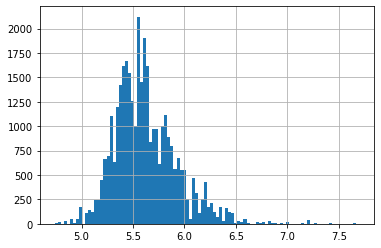

In [26]:
y_train.hist()
plt.show()

In [22]:
X_train['neighborhood']

705              parque_primavera
32267                  zona_rural
27494                    bianucci
5707     chacaras_pocos_de_caldas
24481                      centro
                   ...           
11413            jardim_quisisana
45192         residencial_morumbi
38551            jardim_quisisana
872            jardim_elvira_dias
15963          jardim_dos_estados
Name: neighborhood, Length: 34424, dtype: object

In [44]:
import seaborn as sns

temp = X_train[['neighborhood']].assign(price=10**y)

temp = temp.groupby('neighborhood').agg(
    price = ('price', 'mean'),
    count = ('price', 'count'),
).round(0).sort_values('price').reset_index()



In [47]:
X_train['latitude']

705      missing_value
32267    missing_value
27494        -21.82945
5707     missing_value
24481        -21.78838
             ...      
11413       -21.803255
45192        -21.80749
38551       -21.797683
872      missing_value
15963    missing_value
Name: latitude, Length: 34424, dtype: object

TypeError: 'value' must be an instance of str or bytes, not a float

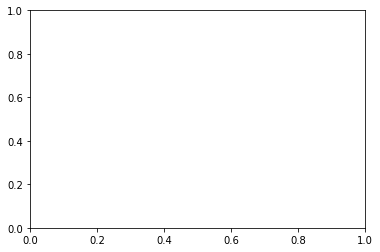

In [45]:
temp = X_train.loc[X_train['neighborhood'].fillna('').str.contains('rura'),["latitude","longitude"]]

sns.scatterplot(data=X_train, x='longitude', y='latitude')
sns.scatterplot(data=temp, x='longitude', y='latitude', color = 'red')

plt.show()

In [18]:
temp[temp['neighborhood'].str.contains('chacara')]

,neighborhood,price,count
0,chacara_santa_barbara,120000.0,4
1,chacara_rancho_azul,130000.0,1
2,chacara_dos_pessegueiros,140000.0,14
16,chacara_alvorada,243256.0,125
75,chacara_sao_pedro,420000.0,1
108,chacaras_pocos_de_caldas,557345.0,145
130,chacara_praia_do_sol,915310.0,71
131,chacara_dos_cravos,922000.0,14
151,chacara_sao_francisco,2452963.0,27
153,chacaras_alto_da_boa_vista,2847500.0,16


In [10]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [32]:
from tqdm import tqdm
list_ = []
for n1 in tqdm(range(len(temp.index))):
    for n2 in range(n1+1,len(temp.index)):
        b1 = temp.index[n1]
        b2 = temp.index[n2]
        c1 = temp['count'][b1]
        c2 = temp['count'][b2]
        r = min(c1/c2, c2/c1)
        list_.append({'b1': b1, 'b2': b2, 'index': similar(b1, b2), 'ratio': r, 'sum': c1+c2})

100%|██████████| 165/165 [00:01<00:00, 126.32it/s]


In [33]:
sim = pd.DataFrame(list_)

In [39]:
sim.sort_values(by=['index','sum','ratio'],ascending=[False,False,True]).to_excel("../bairros_similaridade.xlsx")

In [21]:
sim[sim['index'] < 1].sort_values('index', ascending=False).to_excel("../bairros_similaridade.xlsx")

In [6]:
temp.to_excel("../bairros.xlsx")

In [ ]:
NEIGHBORHOOD_MAPS = {
    'Bortolan Norte I': 'Bortolan Norte',
    'Loteamento Jardim Nova Europa': 'Jardim Europa',
    'Jardim das Hortências': 'Jardim Das Hortênsias'
}

In [15]:
X[X['neighborhood'].str.contains('Bortolan').fillna(False)]['neighborhood'].unique()

array(['Bortolan', 'Bortolan Norte I', 'Bortolan Sul'], dtype=object)

In [9]:
X_train[X_train['neighborhood'] == 'Bortolan Norte I']

,n_parking_spaces,n_bathrooms,n_bedrooms,area,n_suites,latitude,longitude,type_APARTMENT,type_HOME,type_ALLOTMENT_LAND,type_COUNTRY,neighborhood
15291,0.000000,0.0,0.000000,2.853798,0.0,-21.786006,-46.631535,0.0,0.0,1.0,0.0,Bortolan Norte I
13806,0.000000,0.0,0.000000,1.946360,0.0,NaN,NaN,0.0,0.0,1.0,0.0,Bortolan Norte I
17673,0.237015,1.0,0.519236,2.381134,2.0,-21.782818,-46.629542,0.0,1.0,0.0,0.0,Bortolan Norte I
16526,0.000000,0.0,0.000000,2.853798,0.0,NaN,NaN,0.0,0.0,1.0,0.0,Bortolan Norte I
43307,0.000000,0.0,0.000000,2.853798,0.0,-21.786006,-46.631535,0.0,0.0,1.0,0.0,Bortolan Norte I
...,...,...,...,...,...,...,...,...,...,...,...,...
8195,0.000000,0.0,0.000000,2.853798,0.0,NaN,NaN,0.0,0.0,1.0,0.0,Bortolan Norte I
13208,0.000000,0.0,0.000000,2.853798,0.0,-21.786007,-46.631535,0.0,0.0,1.0,0.0,Bortolan Norte I
26804,0.000000,0.0,0.000000,2.853798,0.0,-21.782818,-46.629542,0.0,0.0,1.0,0.0,Bortolan Norte I
27766,0.000000,0.0,0.000000,2.853798,0.0,-21.786006,-46.631535,0.0,0.0,1.0,0.0,Bortolan Norte I
